In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import env

import warnings
warnings.filterwarnings("ignore")

In [2]:
# function to deal with parsing one entry in our log data
def parse_log_entry(entry):
    parts = entry.split()
    output = {}
    output['ip'] = parts[0]
    output['timestamp'] = parts[3][1:].replace(':', ' ', 1)
    output['request_method'] = parts[5][1:]
    output['request_path'] = parts[6]
    output['http_version'] = parts[7][:-1]
    output['status_code'] = parts[8]
    output['size'] = int(parts[9])
    output['user_agent'] = ' '.join(parts[11:]).replace('"', '')
    return pd.Series(output)

In [3]:
#get url connection
url = f'mysql+pymysql://{env.username}:{env.password}@{env.host}/logs'
#read in from sql
df = pd.read_sql('SELECT * FROM api_access', url)
#parse data using function above
df = df.entry.apply(parse_log_entry)
#take a look
df.head()

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
0,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
1,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2,97.105.19.58,16/Apr/2019 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
3,97.105.19.58,16/Apr/2019 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
4,97.105.19.58,16/Apr/2019 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0


In [17]:
#a count of each ip address
df.user_agent.value_counts().head()

python-requests/2.21.0                                                                                                       12001
python-requests/2.20.1                                                                                                        1911
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36       34
Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:66.0) Gecko/20100101 Firefox/66.0                                               8
Slackbot-LinkExpanding 1.0 (+https://api.slack.com/robots)                                                                       7
Name: user_agent, dtype: int64

In [18]:
#what percent is that of the dataset
df.user_agent.value_counts(normalize=True).head()

python-requests/2.21.0                                                                                                       0.858809
python-requests/2.20.1                                                                                                       0.136754
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36    0.002433
Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:66.0) Gecko/20100101 Firefox/66.0                                           0.000572
Slackbot-LinkExpanding 1.0 (+https://api.slack.com/robots)                                                                   0.000501
Name: user_agent, dtype: float64

In [21]:
#turn this into a dataframe
ip_df = pd.DataFrame(df.user_agent.value_counts(dropna=False)).reset_index().\
                rename(columns={'index': 'user_agent', 'user_agent': 'count'})

ip_df

,user_agent,count
0,python-requests/2.21.0,12001
1,python-requests/2.20.1,1911
2,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,34
3,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,8
4,Slackbot-LinkExpanding 1.0 (+https://api.slack...,7
5,Slackbot 1.0 (+https://api.slack.com/robots),6
6,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,4
7,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,2
8,Python-urllib/3.7,1


In [22]:
def value_counts_and_frequencies(s: pd.Series, dropna=True) -> pd.DataFrame:
    return pd.merge(
        s.value_counts(dropna=False).rename('count'),
        s.value_counts(dropna=False, normalize=True).rename('proba'),
        left_index=True,
        right_index=True,
    )


In [24]:
user_agent_df = value_counts_and_frequencies(df.user_agent)
user_agent_df.head()


,count,proba
python-requests/2.21.0,12001,0.858809
python-requests/2.20.1,1911,0.136754
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36",34,0.002433
Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:66.0) Gecko/20100101 Firefox/66.0,8,0.000572
Slackbot-LinkExpanding 1.0 (+https://api.slack.com/robots),7,0.000501


<Axes: >

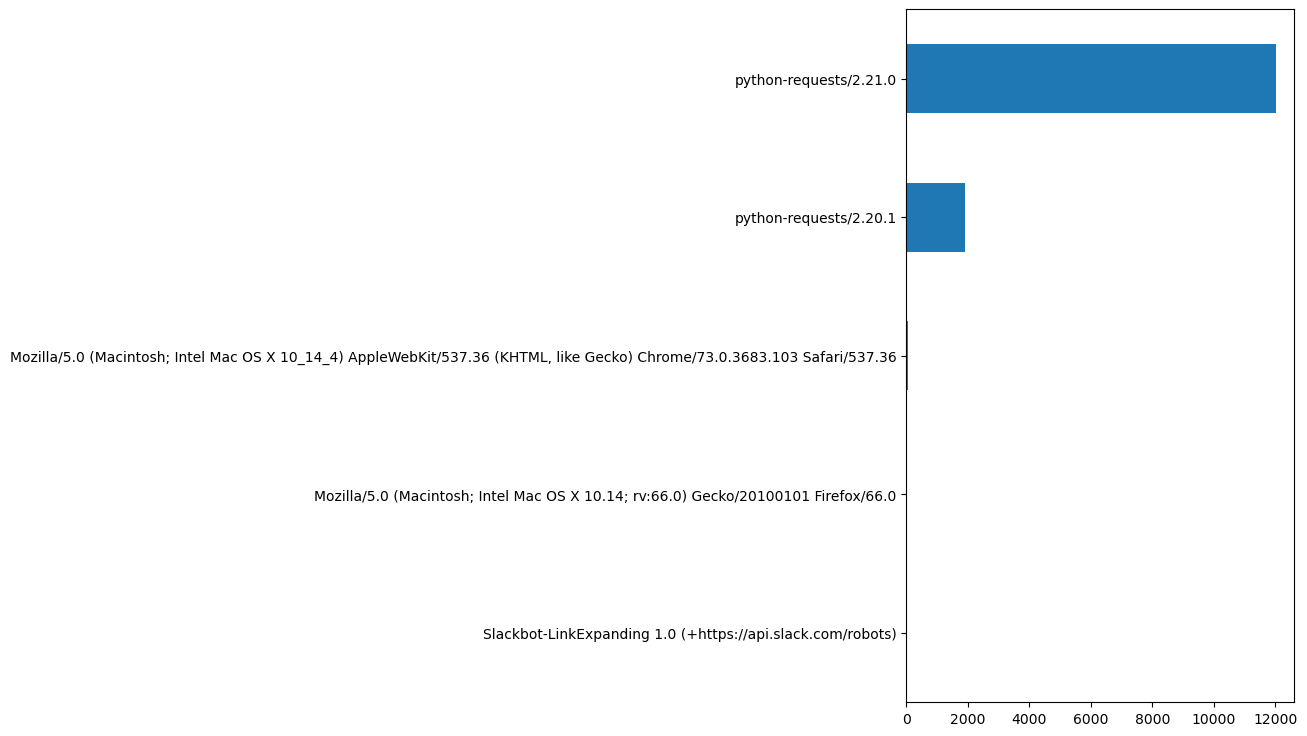

In [25]:
user_agent_df['count'].sort_values().tail(5).plot.barh(figsize=(5, 9))

In [27]:
status_given_ip = (
    df.groupby('user_agent')
    .status_code.value_counts(normalize=True)
    .rename('proba_status_given_ip')
    .reset_index()
)
status_given_ip.head()


,user_agent,status_code,proba_status_given_ip
0,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,200,1.0
1,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,200,1.0
2,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,200,1.0
3,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,200,1.0
4,Python-urllib/3.7,200,1.0


In [28]:
status_given_ip[status_given_ip.status_code != '200']


,user_agent,status_code,proba_status_given_ip
8,python-requests/2.20.1,499,0.002093
10,python-requests/2.21.0,499,0.001000
